<a href="https://colab.research.google.com/github/VitalyGladyshev/med_work/blob/main/%D0%93%D0%BB%D0%B0%D0%B4%D1%8B%D1%88%D0%B5%D0%B2%D0%92%D0%92_HW5_PyHealth_Length_Stay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 5 ГладышевВВ

In [2]:
!pip install pyhealth

### **Step 1: Load dataset**
- **[README]:** We call [pyhealth.datasets](https://pyhealth.readthedocs.io/en/latest/api/datasets.html) to process and obtain the dataset.
  - `root` is the arguments directing to the data folder.
  - `tables` is a list of table names from raw databases, which specifies the information that will be used in building the pipeline. Currently, we provide [MIMIC3Dataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC3Dataset.html), [MIMIC4Dataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC4Dataset.html), [eICUDataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.eICUDataset.html), [OMOPDataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.OMOPDataset.html).
  - `code_mapping [default: None]` asks a directionary input, specifying the new coding systems for each data table. For example, `{"NDC": ("ATC", {"target_kwargs": {"level": 3}})}` means that our pyhealth will automatically change the codings from `NDC` into ATC-3 level for tables if any.
  - `dev`: if set `True`, will only load a smaller set of patients.
- **[Next Step]:** This `pyhealth.datasets` object will be used in **Step 2**.

In [3]:
from pyhealth.datasets import MIMIC3Dataset

mimic3_ds = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        code_mapping={},
        dev=True,
)

mimic3_ds.stat()

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
finish basic patient information parsing : 3.5160646438598633s
finish parsing DIAGNOSES_ICD : 2.3197708129882812s
finish parsing PROCEDURES_ICD : 1.7691106796264648s
finish parsing PRESCRIPTIONS : 13.34662914276123s


Mapping codes: 100%|██████████| 1000/1000 [00:00<00:00, 18732.43it/s]



Statistics of base dataset (dev=True):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1000
	- Number of visits: 1054
	- Number of visits per patient: 1.0540
	- Number of events per visit in DIAGNOSES_ICD: 9.2068
	- Number of events per visit in PROCEDURES_ICD: 3.0380
	- Number of events per visit in PRESCRIPTIONS: 29.2457



'\nStatistics of base dataset (dev=True):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 1000\n\t- Number of visits: 1054\n\t- Number of visits per patient: 1.0540\n\t- Number of events per visit in DIAGNOSES_ICD: 9.2068\n\t- Number of events per visit in PROCEDURES_ICD: 3.0380\n\t- Number of events per visit in PRESCRIPTIONS: 29.2457\n'

In [4]:
# data format
mimic3_ds.info()


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



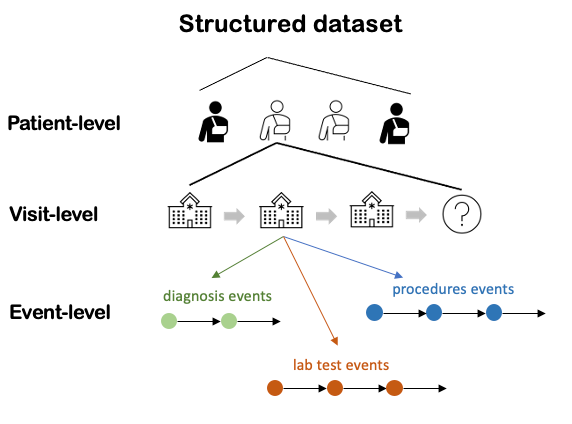

In [5]:
# mimic3_ds.patients
# mimic3_ds.patients['947']
# mimic3_ds.patients['947'].visits
# mimic3_ds.patients['947'].visits['100999']
# mimic3_ds.patients['947'].visits['100999'].get_code_list('DIAGNOSES_ICD')

### **Step 2: Define healthcare task**
- **[README]:** This step assigns a **task function** to the dataset for data loading [pyhealth.tasks](https://pyhealth.readthedocs.io/en/latest/api/tasks.html). The **task function** specifics how to process each pateint's data into a set of samples for the downstream machine learning models.
- **[Next Step]:** This `pyhealth.tasks` object will be used in **Step 3**.

In [6]:
from pyhealth.tasks import length_of_stay_prediction_mimic3_fn

task_mimic3_ds = mimic3_ds.set_task(task_fn=length_of_stay_prediction_mimic3_fn)
# stats info
task_mimic3_ds.stat()

Generating samples for length_of_stay_prediction_mimic3_fn: 100%|██████████| 1000/1000 [00:00<00:00, 1508.35it/s]

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: length_of_stay_prediction_mimic3_fn
	- Number of samples: 896
	- Number of patients: 886
	- Number of visits: 896
	- Number of visits per patient: 1.0113
	- conditions:
		- Number of conditions per sample: 9.7377
		- Number of unique conditions: 1699
		- Distribution of conditions (Top-10): [('4019', 324), ('41401', 167), ('25000', 151), ('4280', 147), ('5849', 121), ('2724', 118), ('42731', 110), ('51881', 89), ('53081', 88), ('2720', 85)]
	- procedures:
		- Number of procedures per sample: 3.5647
		- Number of unique procedures: 558
		- Distribution of procedures (Top-10): [('3893', 155), ('9671', 139), ('9604', 123), ('9904', 100), ('8856', 85), ('966', 64), ('3615', 61), ('3961', 59), ('3722', 58), ('3891', 55)]
	- drugs:
		- Number of drugs per sample: 32.5804
		- Number of unique drugs: 1911
		- Distribution of drugs (Top-10): [('00338004904', 388), ('00008084199', 362), ('00338004903', 317), ('00338001702', 305), (

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: length_of_stay_prediction_mimic3_fn\n\t- Number of samples: 896\n\t- Number of patients: 886\n\t- Number of visits: 896\n\t- Number of visits per patient: 1.0113\n\t- conditions:\n\t\t- Number of conditions per sample: 9.7377\n\t\t- Number of unique conditions: 1699\n\t\t- Distribution of conditions (Top-10): [('4019', 324), ('41401', 167), ('25000', 151), ('4280', 147), ('5849', 121), ('2724', 118), ('42731', 110), ('51881', 89), ('53081', 88), ('2720', 85)]\n\t- procedures:\n\t\t- Number of procedures per sample: 3.5647\n\t\t- Number of unique procedures: 558\n\t\t- Distribution of procedures (Top-10): [('3893', 155), ('9671', 139), ('9604', 123), ('9904', 100), ('8856', 85), ('966', 64), ('3615', 61), ('3961', 59), ('3722', 58), ('3891', 55)]\n\t- drugs:\n\t\t- Number of drugs per sample: 32.5804\n\t\t- Number of unique drugs: 1911\n\t\t- Distribution of drugs (Top-10): [('00338004904', 388), ('00008084199', 362),

In [7]:
# show a data sample
task_mimic3_ds.samples[0]

{'visit_id': '100000',
 'patient_id': '1',
 'conditions': [['86121',
   'V4589',
   '25082',
   '79902',
   '19889',
   '36201',
   '99681',
   '27802',
   '30593']],
 'procedures': [['3895', '544', '9618', '8472']],
 'drugs': [['00008092355',
   '00338001702',
   '00641040025',
   '00517090125',
   '00517391025',
   '00338070341',
   '00074233411',
   '00182844789',
   '63739008901',
   '66689036430',
   '00074241512',
   '00074131230',
   '00904526161',
   '00006494300',
   '00406051201',
   '00004200278',
   '00045025501',
   '00085172202',
   '00766145010',
   '52959036100',
   '00029608031',
   '00310013239',
   '51079068320']],
 'label': 0}

In [8]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(task_mimic3_ds, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

### **Step 3: Define ML Model**
- **[README]:** We initialize an ML model for the healthcare task by calling [pyhealth.models](https://pyhealth.readthedocs.io/en/latest/api/models.html).
- **[Next Step]:** This `pyhealth.models` object will be used in **Step 4**.
- **[Other Use Case]:** Our `pyhealth.models` object is as general as any instance from `torch.nn.Module`. Users may use it separately for supporting any other customized pipeline.

In [9]:
from pyhealth.models import Transformer

model = Transformer(
    dataset=task_mimic3_ds,
    # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
    feature_keys=["conditions", "procedures"],
    label_key="label",
    mode="multiclass",
    num_layers=2,
)

### **Step 4: Model Training**
- **[README]:** We call our [pyhealth.train.Trainer](https://pyhealth.readthedocs.io/en/latest/api/trainer.html) to train the model by giving the `train_loader`, the `val_loader`, val_metric, and specify other arguemnts, such as epochs, optimizer, learning rate, etc. The trainer will automatically save the best model and output the path in the end.
- **[Next Step]:** The best model will be used in **Step 5** for evaluation.

In [10]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model, metrics=["accuracy", "jaccard_weighted"])

trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=5,
    monitor="jaccard_weighted",
)

Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(1701, 128, padding_idx=0)
    (procedures): Embedding(560, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0-1): 2 x TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='none')
          )
      

INFO:pyhealth.trainer:Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(1701, 128, padding_idx=0)
    (procedures): Embedding(560, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0-1): 2 x TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='non

Metrics: ['accuracy', 'jaccard_weighted']


INFO:pyhealth.trainer:Metrics: ['accuracy', 'jaccard_weighted']


Device: cpu


INFO:pyhealth.trainer:Device: cpu


INFO:pyhealth.trainer:


Training:


INFO:pyhealth.trainer:Training:


Batch size: 64


INFO:pyhealth.trainer:Batch size: 64


Optimizer: <class 'torch.optim.adam.Adam'>


INFO:pyhealth.trainer:Optimizer: <class 'torch.optim.adam.Adam'>


Optimizer params: {'lr': 0.001}


INFO:pyhealth.trainer:Optimizer params: {'lr': 0.001}


Weight decay: 0.0


INFO:pyhealth.trainer:Weight decay: 0.0


Max grad norm: None


INFO:pyhealth.trainer:Max grad norm: None


Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x788efa554bb0>


INFO:pyhealth.trainer:Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x788efa554bb0>


Monitor: jaccard_weighted


INFO:pyhealth.trainer:Monitor: jaccard_weighted


Monitor criterion: max


INFO:pyhealth.trainer:Monitor criterion: max


Epochs: 5


INFO:pyhealth.trainer:Epochs: 5


INFO:pyhealth.trainer:


Epoch 0 / 5:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-0, step-12 ---


INFO:pyhealth.trainer:--- Train epoch-0, step-12 ---


loss: 4.8163


INFO:pyhealth.trainer:loss: 4.8163
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 46.28it/s]

--- Eval epoch-0, step-12 ---



INFO:pyhealth.trainer:--- Eval epoch-0, step-12 ---


accuracy: 0.3889


INFO:pyhealth.trainer:accuracy: 0.3889


jaccard_weighted: 0.2050


INFO:pyhealth.trainer:jaccard_weighted: 0.2050


loss: 2.4320


INFO:pyhealth.trainer:loss: 2.4320


New best jaccard_weighted score (0.2050) at epoch-0, step-12


INFO:pyhealth.trainer:New best jaccard_weighted score (0.2050) at epoch-0, step-12


INFO:pyhealth.trainer:


Epoch 1 / 5:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-1, step-24 ---


INFO:pyhealth.trainer:--- Train epoch-1, step-24 ---


loss: 3.7233


INFO:pyhealth.trainer:loss: 3.7233
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 31.35it/s]

--- Eval epoch-1, step-24 ---



INFO:pyhealth.trainer:--- Eval epoch-1, step-24 ---


accuracy: 0.4333


INFO:pyhealth.trainer:accuracy: 0.4333


jaccard_weighted: 0.2039


INFO:pyhealth.trainer:jaccard_weighted: 0.2039


loss: 2.4946


INFO:pyhealth.trainer:loss: 2.4946


INFO:pyhealth.trainer:


Epoch 2 / 5:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-2, step-36 ---


INFO:pyhealth.trainer:--- Train epoch-2, step-36 ---


loss: 3.3694


INFO:pyhealth.trainer:loss: 3.3694
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 43.59it/s]

--- Eval epoch-2, step-36 ---



INFO:pyhealth.trainer:--- Eval epoch-2, step-36 ---


accuracy: 0.4000


INFO:pyhealth.trainer:accuracy: 0.4000


jaccard_weighted: 0.1985


INFO:pyhealth.trainer:jaccard_weighted: 0.1985


loss: 2.3769


INFO:pyhealth.trainer:loss: 2.3769


INFO:pyhealth.trainer:


Epoch 3 / 5:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-3, step-48 ---


INFO:pyhealth.trainer:--- Train epoch-3, step-48 ---


loss: 3.1341


INFO:pyhealth.trainer:loss: 3.1341
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 35.97it/s]

--- Eval epoch-3, step-48 ---



INFO:pyhealth.trainer:--- Eval epoch-3, step-48 ---


accuracy: 0.3556


INFO:pyhealth.trainer:accuracy: 0.3556


jaccard_weighted: 0.1734


INFO:pyhealth.trainer:jaccard_weighted: 0.1734


loss: 2.3201


INFO:pyhealth.trainer:loss: 2.3201


INFO:pyhealth.trainer:


Epoch 4 / 5:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-4, step-60 ---


INFO:pyhealth.trainer:--- Train epoch-4, step-60 ---


loss: 2.9414


INFO:pyhealth.trainer:loss: 2.9414
Evaluation: 100%|██████████| 2/2 [00:00<00:00, 18.65it/s]

--- Eval epoch-4, step-60 ---



INFO:pyhealth.trainer:--- Eval epoch-4, step-60 ---


accuracy: 0.3667


INFO:pyhealth.trainer:accuracy: 0.3667


jaccard_weighted: 0.1805


INFO:pyhealth.trainer:jaccard_weighted: 0.1805


loss: 2.2747


INFO:pyhealth.trainer:loss: 2.2747


Loaded best model


INFO:pyhealth.trainer:Loaded best model


### **Step 5: Evaluation**

In [11]:
# option 1: use our built-in evaluation metric
score = trainer.evaluate(test_loader)
print (score)

# option 2: use our pyhealth.metrics to evaluate
from pyhealth.metrics.multiclass import multiclass_metrics_fn

y_true, y_prob, loss = trainer.inference(test_loader)
multiclass_metrics_fn(y_true, y_prob, metrics=["accuracy", "f1_macro", "f1_micro", "cohen_kappa"])

Evaluation: 100%|██████████| 2/2 [00:00<00:00, 27.29it/s]


{'accuracy': 0.35555555555555557, 'jaccard_weighted': 0.17595132051883106, 'loss': 2.6411523818969727}


Evaluation: 100%|██████████| 2/2 [00:00<00:00, 22.20it/s]


{'accuracy': 0.35555555555555557,
 'f1_macro': 0.138514714776397,
 'f1_micro': 0.35555555555555557,
 'cohen_kappa': 0.04448105436573313}

# Заключение

Библиотека PyHealth позволяет сформировать полный пайплайн машинного обучения для автоматизации обработки медицинских данных.<br>
Предусмотрена возможность удобного подключения больших, сложно структурированных, датасетов медицинской направленности, таких как MIMIC-III, MIMIC-IV и т.д. Представленны средства для формирования моделей, оценки и инференса.<br>
Библиотека хорошо документирована. Представлено большое количество обучающих материалов. Описана возможность подключения сторонних источников данных и датасетов.<br>
Для ознакомления использован туториал с пайплайном предсказания продолжительности пребывания в медицинском стационаре<br>
Объём материала очень большой, интересный и вполне может быть предметом отдельного курса.